# Weight and Calories over Time

This is a data visualization of my calorie intake and body mass over most of 2016 and 2017.

The most interesting correlation I have drawn from the output is that my mass reduced when
I was working for Podio and following healthy practices (i.e. lower-stress work environment,
regular exercise) and that my mass increased when I was working for Broadvine and was less healthy
(i.e. higher-stress work environment, very little exercise).

In [1]:
import numpy as np
import pandas as pd
%matplotlib inline

def parser(x):
    return pd.datetime.strptime(x, '%Y-%m-%d')

In [2]:
# # Experiments with resampling
# mock_gapped_data = [(parser('2017-01-01'), 100.0), (parser('2017-03-01'), 200.0)]
# mock_gapped_df = pd.DataFrame.from_records(mock_gapped_data, columns=['Date', 'Junk Data']).set_index('Date')
# mock_gapped_df = mock_gapped_df.resample('D', label='Date').interpolate()
# # mock_gapped_df

In [3]:
# read calorie data from MyFitnessPal exported CSV
nutrition_df = pd.read_csv('data/myfitnesspal-export/Nutrition-Summary-2016-05-08-to-2017-12-07.csv', parse_dates=['Date'], date_parser=parser)
daily_calories = nutrition_df[['Date', 'Calories']].groupby('Date').sum()

In [4]:
# interpolate irregular daily calory data to every day
daily_calories_resampled = daily_calories.resample('D', label='Date').interpolate()
# daily_calories_resampled.plot.line(figsize=(15,5))

# ...and convert it to a rolling 7-day mean to reduce spikiness
calories_rolling_mean_series = daily_calories_resampled.rolling(window=7, center=False).mean()
calories_rolling_mean_df = pd.DataFrame(calories_rolling_mean_series)
# calories_rolling_mean_df.plot.line(figsize=(15,5))

In [5]:
# read body mass data from Apple Health exported XML
import xml.etree.ElementTree as ET
tree = ET.parse('data/apple-health-export/export.xml')

In [6]:
# build dataframe from the XML records
root = tree.getroot()
weight_records = root.findall(".//Record[@type='HKQuantityTypeIdentifierBodyMass']")
weight_tuples = [(parser(r.get('creationDate').split(' ')[0]), float(r.get('value'))) for r in weight_records]
daily_weight_df = pd.DataFrame(weight_tuples, columns=['Date', 'Weight']).groupby('Date').max()

# interpolate any missed days
daily_weight_resampled = daily_weight_df.resample('D', label='Date').interpolate()

# ...and convert it to a rolling 7-day mean to reduce spikiness
weight_rolling_series = daily_weight_resampled.rolling(window=7, center=False).mean()
weight_rolling_mean_df = pd.DataFrame(weight_rolling_series)
# weight_rolling_mean_df[parser('2016-01-01'):].plot.line(figsize=(15,5))

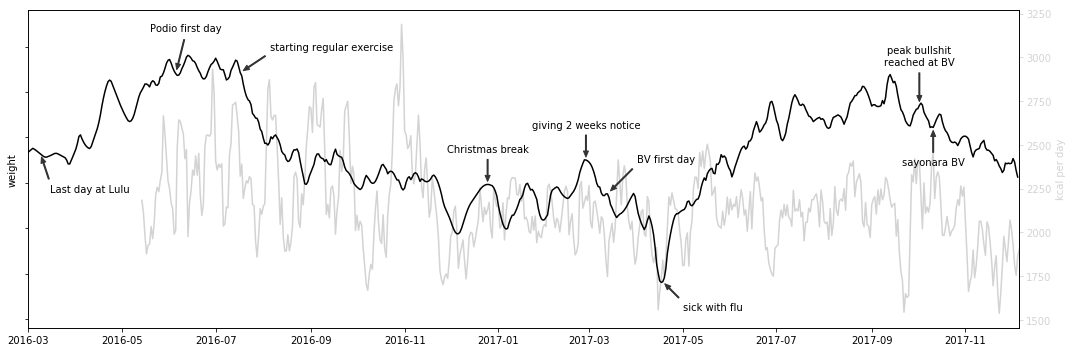

In [7]:
# plot all that data with custom settings

from matplotlib import pyplot as plt
%matplotlib inline

plottable_weight = weight_rolling_mean_df[parser('2016-03-01'):]
plottable_calories = calories_rolling_mean_df

fig, ax1 = plt.subplots(figsize=(15, 5), )
# ax1.set_xlabel('date')

ax1.plot(plottable_calories, color='lightgrey')
ax1.set_ylabel('kcal per day', color='lightgrey')
ax1.tick_params('y', colors='lightgrey')

ax2 = ax1.twinx()
ax2.plot(plottable_weight, color='black')
ax2.set_ylabel('weight')
ax2.yaxis.set_ticklabels([])
ax2.tick_params('y', colors='black')

ax1.yaxis.set_ticks_position('right')
ax1.yaxis.set_label_position('right')
ax2.yaxis.set_ticks_position('left')
ax2.yaxis.set_label_position('left')

def add_annotation(phrase, date_str, x=0, y=50, horizontalalignment='center', verticalalignment='top'):
    _date = parser(date_str)
    xy = (_date, plottable_weight['Weight'][_date])
    color = (.2, .2, .2)
    ax2.annotate(
        phrase,
        xy=xy, xycoords='data',
        xytext=(x, y), textcoords='offset points',
        arrowprops=dict(fc=color, ec=color, width=1, headwidth=5, headlength=6, shrink=0.1),
        horizontalalignment=horizontalalignment,
        verticalalignment=verticalalignment
    )

add_annotation('Last day at Lulu', '2016-03-09', x=10, y=-30, horizontalalignment='left')
add_annotation('Podio first day', '2016-06-05', x=10)
add_annotation('starting regular exercise', '2016-07-17', x=30, y=30, horizontalalignment='left')
add_annotation('Christmas break', '2016-12-25', x=0, y=40)
add_annotation('giving 2 weeks notice', '2017-02-27', x=0, y=40)
add_annotation('BV first day', '2017-03-13', x=30, y=40, horizontalalignment='left')
add_annotation('sick with flu', '2017-04-18', x=20, y=-20, horizontalalignment='left')
add_annotation('peak bullshit\nreached at BV', '2017-10-02', x=0, y=60)
add_annotation('sayonara BV', '2017-10-11', x=0, y=-30)

fig.tight_layout()
plt.margins(0.0, 0.2)

# fig.savefig('weight.png', dpi=300)
plt.show()